# Feature Store Ingest

Read local DataFrame, file, URL, or source into the feature store
Ingest reads from the source, run the graph transformations, infers metadata and stats
and writes the results to the default of specified targets.

## Creating Project

In [1]:
import mlrun
import mlrun.feature_store as fstore
from  mlrun.datastore.sources import CSVSource
from mlrun.feature_store.steps import *
from mlrun.features import MinMaxValidator
import pandas as pd
import datetime

In [2]:
# Initialize the MLRun project object
project = mlrun.get_or_create_project('ingest', context="./", user_project=True)

> 2022-01-31 13:52:16,939 [info] loaded project ingest from MLRun DB


## Create Sample Data For Demo

In [3]:
quotes = pd.DataFrame(
    {
        "time": [
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.030"),
            pd.Timestamp("2016-05-25 13:30:00.041"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
            pd.Timestamp("2016-05-25 13:30:00.049"),
            pd.Timestamp("2016-05-25 13:30:00.072"),
            pd.Timestamp("2016-05-25 13:30:00.075"),
        ],
        "ticker": ["GOOG", "MSFT", "MSFT", "MSFT", "GOOG", "AAPL", "GOOG", "MSFT"],
        "bid": [720.50, 51.95, 51.97, 51.99, 720.50, 97.99, 720.50, 52.01],
        "ask": [720.93, 51.96, 51.98, 52.00, 720.93, 98.01, 720.88, 52.03],
    }
)

# move date:
max_date = quotes["time"].max()
now_date = datetime.datetime.now()
delta = now_date - max_date
quotes["time"] = quotes["time"] + delta

In [4]:
quotes

,time,ticker,bid,ask
0,2022-01-31 13:52:16.905388,GOOG,720.50,720.93
1,2022-01-31 13:52:16.905388,MSFT,51.95,51.96
2,2022-01-31 13:52:16.912388,MSFT,51.97,51.98
3,2022-01-31 13:52:16.923388,MSFT,51.99,52.00
4,2022-01-31 13:52:16.930388,GOOG,720.50,720.93
5,2022-01-31 13:52:16.931388,AAPL,97.99,98.01
6,2022-01-31 13:52:16.954388,GOOG,720.50,720.88
7,2022-01-31 13:52:16.957388,MSFT,52.01,52.03


## Build Advanced Feature Set - With Feature Engineering Pipeline

Define a custom pipeline step (python class)

In [5]:
class MyMap(MapClass):
    def __init__(self, multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self._multiplier = multiplier

    def do(self, event):
        event["multi"] = event["bid"] * self._multiplier
        return event

Build and show the transformatiom pipeline

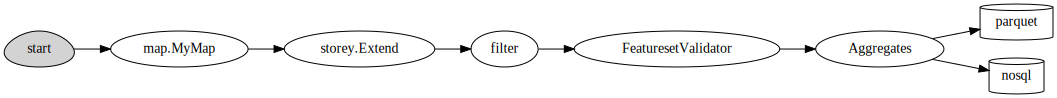

In [6]:
quotes_set = fstore.FeatureSet("stock-quotes", entities=[fstore.Entity("ticker")])

quotes_set.graph.to("map.MyMap", multiplier=3).to(
    "storey.Extend", _fn="({'extra': event['bid'] * 77})"
).to("storey.Filter", "filter", _fn="(event['bid'] > 51.92)").to(
    FeaturesetValidator()
)

quotes_set.add_aggregation("ask", ["sum", "max"], "1h", "10m", name="asks1")
quotes_set.add_aggregation("ask", ["sum", "max"], "5h", "10m", name="asks5")
quotes_set.add_aggregation("bid", ["min", "max"], "1h", "10m", name="bids")

# add feature validation policy
quotes_set["bid"] = fstore.Feature(
    validator=MinMaxValidator(min=52, severity="info")
)

# add default target definitions and plot
quotes_set.set_targets()
quotes_set.plot(rankdir="LR", with_targets=True)

Saving the feature set in the feature store 

In [7]:
quotes_set.save()

Creating the data source of the feature set to apply the ingest on:

In [8]:
data_uri = 'quotes.csv'
quotes.to_csv(data_uri, index=False)
source = CSVSource('quotes', data_uri).to_dict()
source

## Import ingest function

In [10]:
ingest_fn = mlrun.import_function("function.yaml")

## Running the function locally

In [11]:
ingest_run = ingest_fn.run(
    handler="ingest",
    params={
        "featureset": quotes_set.uri,
        "source": source,
    },
    local=True,
)

> 2022-01-31 13:52:17,201 [info] starting run ingest-ingest uid=4bd5d12691a8439d90bf53847f59df1a DB=http://mlrun-api:8080
> 2022-01-31 13:52:17,354 [info] Ingesting the FeatureSet: store://feature-sets/ingest-yonatan/stock-quotes
> 2022-01-31 13:52:17,427 [info] starting ingestion task to store://feature-sets/ingest-yonatan/stock-quotes:latest.
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 13:52:19.466055 args={'min': 52, 'value': 51.95}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 13:52:19.466072 args={'min': 52, 'value': 51.97}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 13:52:19.466085 args={'min': 52, 'value': 51.99}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 13:52:19.671677 args={'min': 52, 'value': 51.95}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 13:52:19.671692 args={'min': 52, 'value': 51.97}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 13:52:19.671

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
ingest-yonatan,...7f59df1a,0,Jan 31 13:52:17,completed,ingest-ingest,v3io_user=yonatankind=owner=yonatanhost=jupyter-yoni-647b99c95d-w4jlc,,"featureset=store://feature-sets/ingest-yonatan/stock-quotessource={'kind': 'csv', 'name': 'quotes', 'path': 'quotes.csv'}infer_options=63overwrite=Nonetargets=None",featureset=store://feature-sets/ingest-yonatan/stock-quotes,


> 2022-01-31 13:52:20,045 [info] run executed, status=completed


## View of the targets' state after run

In [19]:
fstore.get_feature_set(ingest_run.outputs['featureset']).status.state

'created'